In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_cora import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.gat import StructuralOmegaGATCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logs_filename = 'logs/omega_function/cora/06-1-structural_gat_cossim_gamma_function.log'

In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=logs_filename
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

In [8]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [9]:
data = prepare_adjencency(data)

## Training

In [12]:
for run in range(30):
    for n_layers_gat in range(1, 4):
        omega = StructuralOmegaGATCosSim(
            device=device,
            dataset='cora',
            in_channels=data.x.shape[1],
            n_layers_gat=n_layers_gat,
            run=run,
            eval_steps=10,
            epochs=1000)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [13]:
n_layers_gat = 1

In [16]:
metrics = StructuralOmegaGATCosSim.read_metrics(
    dataset='cora',
    n_layers_gat=n_layers_gat)
print(metrics.shape)
metrics.head()

(3030, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.524619,0.515599,0.531577,0.652535,0.692296,0.656862
1,0,10,0.362698,0.464900,0.487736,0.981846,0.814994,0.770317
2,0,20,0.312371,0.455997,0.477490,0.986542,0.790697,0.760655
3,0,30,0.281126,0.442089,0.467982,0.990727,0.788914,0.757068
4,0,40,0.257024,0.431115,0.457936,0.990970,0.785263,0.759415


### Sumarize metrics per epoch

In [17]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [18]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [19]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.525798,0.001617,0.514172,0.001507,0.531836,0.001106,0.636364,0.016551,0.695989,0.013503,0.649586,0.010838
10,0.363562,0.002492,0.462552,0.003968,0.488563,0.002249,0.984641,0.003046,0.824060,0.019555,0.763691,0.008057
20,0.312187,0.001748,0.450641,0.005111,0.477298,0.003186,0.992470,0.003685,0.808787,0.020602,0.757192,0.010133
30,0.280348,0.001397,0.437516,0.005389,0.467302,0.003690,0.994766,0.003653,0.807869,0.019476,0.753394,0.010071
40,0.256658,0.001233,0.426821,0.005708,0.458643,0.004216,0.995964,0.003378,0.806816,0.018418,0.751696,0.010690


In [20]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
10,0.363562,0.002492,0.462552,0.003968,0.488563,0.002249,0.984641,0.003046,0.824060,0.019555,0.763691,0.008057
20,0.312187,0.001748,0.450641,0.005111,0.477298,0.003186,0.992470,0.003685,0.808787,0.020602,0.757192,0.010133
30,0.280348,0.001397,0.437516,0.005389,0.467302,0.003690,0.994766,0.003653,0.807869,0.019476,0.753394,0.010071
40,0.256658,0.001233,0.426821,0.005708,0.458643,0.004216,0.995964,0.003378,0.806816,0.018418,0.751696,0.010690
50,0.237619,0.001179,0.417813,0.005629,0.451521,0.004371,0.996992,0.003171,0.806694,0.016340,0.751053,0.010209


/tmp/ipykernel_150025/990680817.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_150025/990680817.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_150025/990680817.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavio

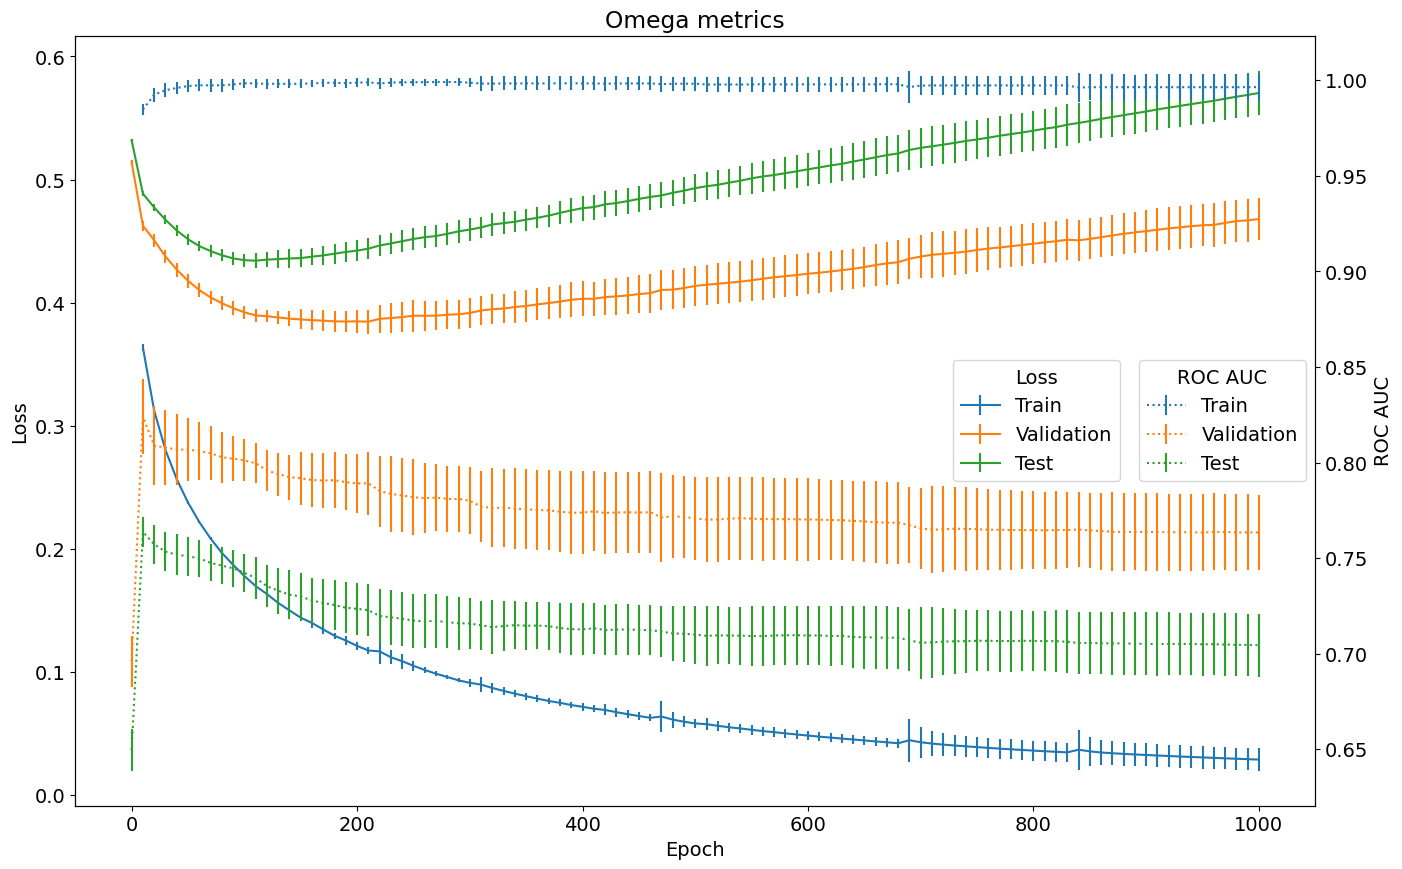

In [21]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/cora/structural_omega_gat_cossim_training_metrics_{n_layers_gat}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [18]:
n_layers_list = range(1, 4)

In [19]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_gat in n_layers_list:
    metrics = StructuralOmegaGATCosSim.read_metrics(n_layers_gat=n_layers_gat)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_gat] = auc_val
    mean_loss_val_dict[n_layers_gat] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_gat] = auc_val
    std_loss_val_dict[n_layers_gat] = loss_val

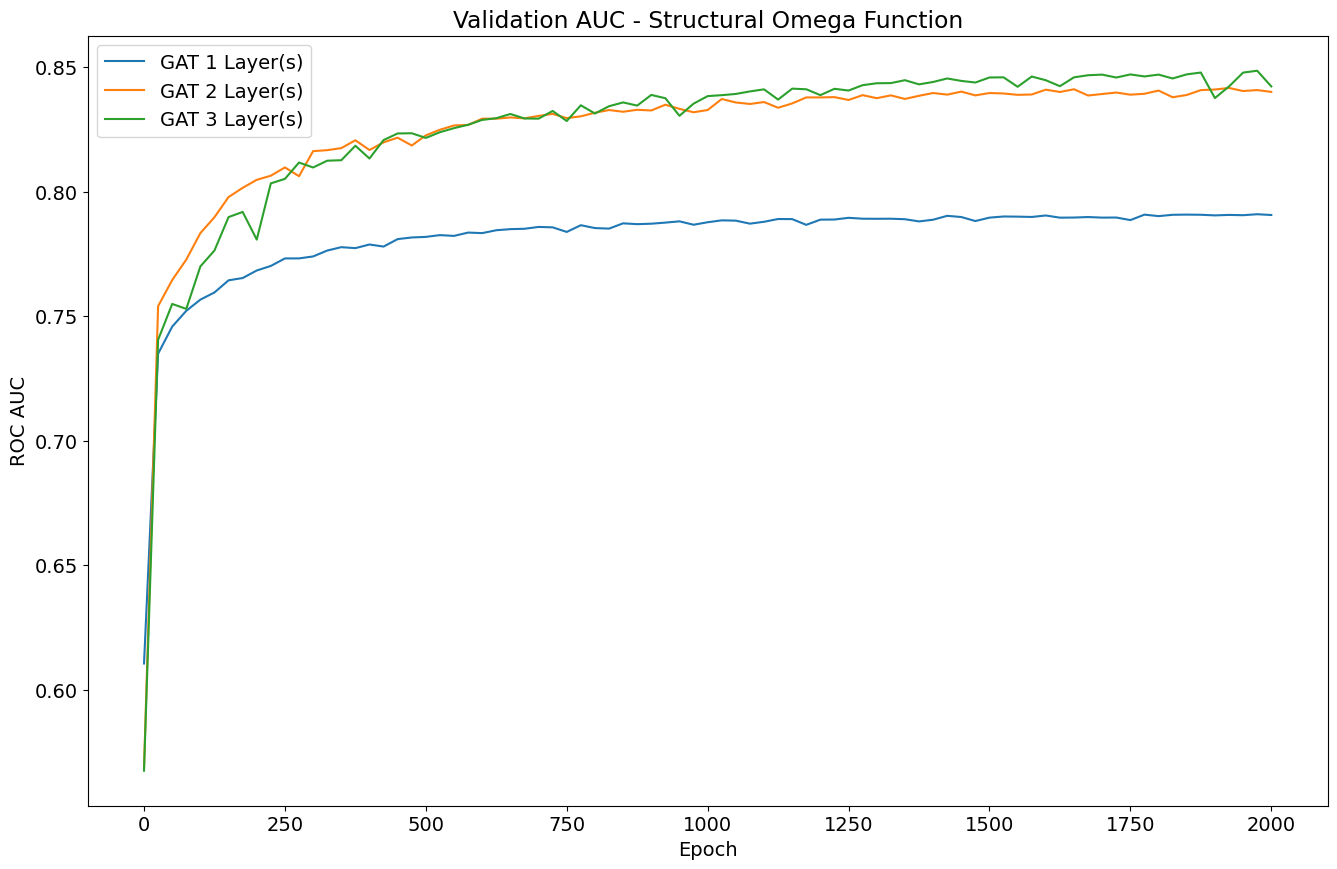

In [20]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    # ax1.errorbar(
    #     mean_auc_val_dict[n_layers].index,
    #     mean_auc_val_dict[n_layers],
    #     yerr=std_auc_val_dict[n_layers],
    #     ls='-',
    #     label=f'GAT {n_layers} Layer(s)')

    ax1.plot(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        # yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'GAT {n_layers} Layer(s)')

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [21]:
n_layers_list = range(1, 4)

In [23]:
full_metrics = []
for n_layers_gat in n_layers_list:
    metrics = StructuralOmegaGATCosSim.read_metrics(
        n_layers_gat=n_layers_gat)
    metrics['n_layers_gat'] = n_layers_gat
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [24]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                2.000000
epoch           1825.000000
loss_train         0.426164
loss_val           0.465522
loss_test          0.504632
auc_train          0.867122
auc_val            0.850931
auc_test           0.823648
n_layers_gat       3.000000
Name: 235, dtype: float64

In [25]:
best_model_metrics.to_json('models/structural_omega_gat_cossim/best_model_info.json')

### Load data

In [35]:
dataset = load_dataset()
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device='cpu', remove_from_data=False)
data = prepare_adjencency(data)

### Load model

In [37]:
omega = StructuralOmegaGATCosSim.load_model(
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device='cpu',
    n_layers_gat=int(best_model_metrics['n_layers_gat']))

### Score model

In [38]:
all_edges = torch.concat([edges_train, edges_val, edges_test], dim=1)
all_edges.shape

torch.Size([2, 1166243])

In [39]:
preds = omega.forward(all_edges, data.x, data.adj_t).to('cpu').detach().numpy()
preds[:5]

array([[0.89256084],
       [0.12552461],
       [0.41810793],
       [0.6203384 ],
       [0.17901051]], dtype=float32)

In [40]:
theta = omega.is_same_class(all_edges, data.y).to('cpu').detach().numpy()

In [41]:
roc_auc_score(theta, preds)

0.8447623999376126

In [42]:
theta.mean()

0.655083031580897

In [43]:
preds.mean()

0.76388484

### Save output

In [44]:
cpu_edges = all_edges.to('cpu').numpy()
edges_gamma_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'gamma_pred': preds[:,0]
})
print(edges_gamma_df.shape)
edges_gamma_df.head()

(1166243, 3)


,source,target,gamma_pred
0,104447,13091,0.892561
1,15858,47283,0.125525
2,107156,69161,0.418108
3,107156,136440,0.620338
4,107156,107366,0.179011


In [45]:
os.makedirs('data/structural_omega_gat_cossim', exist_ok=True)
edges_gamma_df.to_csv('data/structural_omega_gat_cossim/06-1_omega_scored_edges.csv', index=False)

Text(0.5, 1.0, 'Omega distribution over all edges')

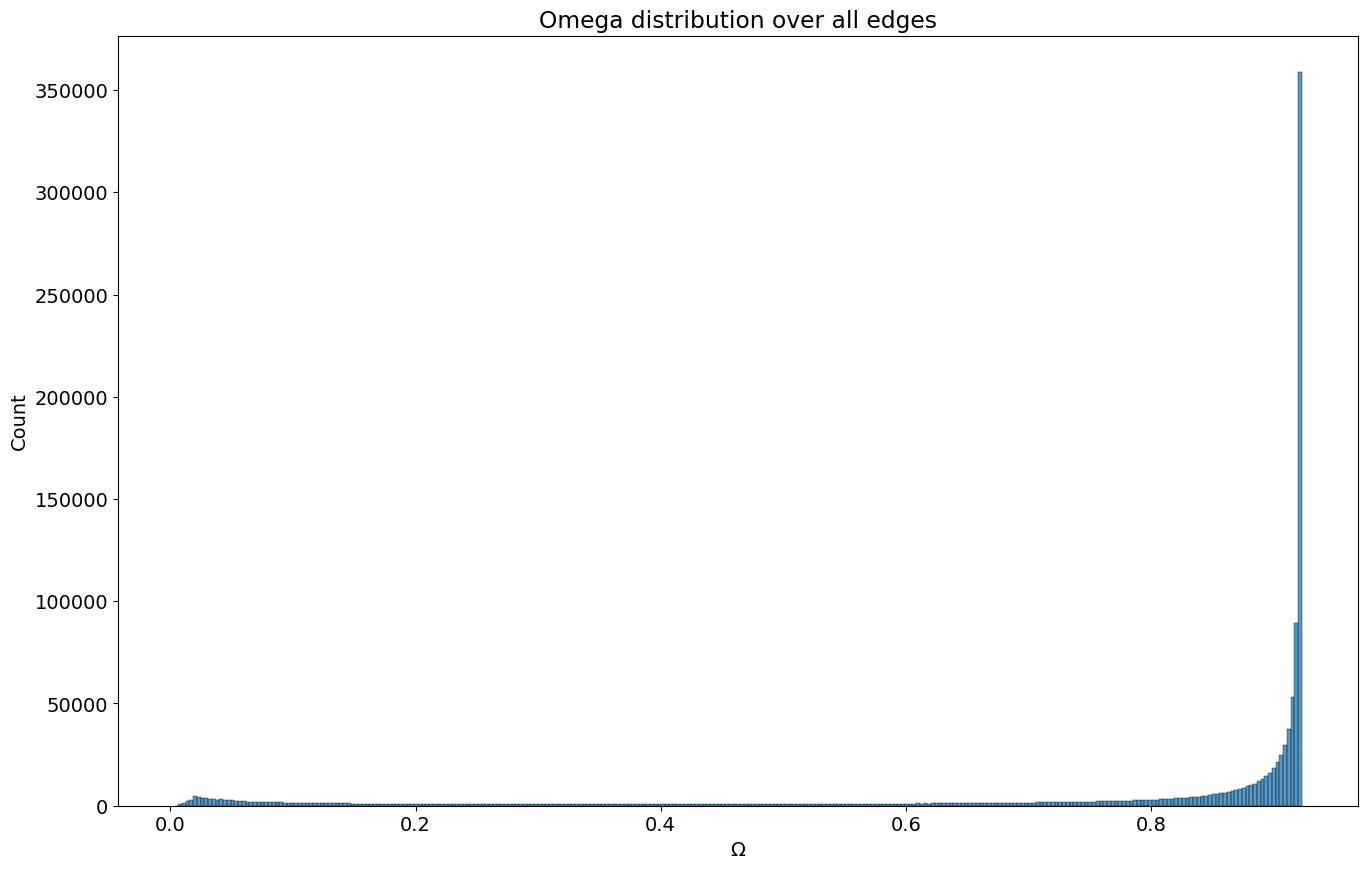

In [46]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_gamma_df['gamma_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
# plt.savefig('reports/images/best_omega_distribution.png')